# Block vs non-block, normalisation vs non-normalisation - One Dimensional analysis, using user RL code and experimental LM data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

In [2]:
exp_data_3d = tifffile.imread('../testdata/data.tif')

In [3]:
exp_data_3d.shape

(60, 1026, 1544)

In [4]:
exp_data_3d.dtype

dtype('uint8')

Choose a single line as data

In [6]:
data = exp_data_3d[30,513,:]

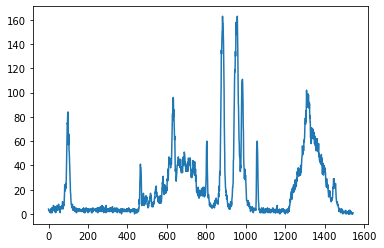

In [7]:
plt.plot(data)

In [8]:
data.shape

(1544,)

## Create a cropped region

In [9]:
x_crop_0, x_crop_1 = 400 , 1000
data_crop = data[x_crop_0:x_crop_1]

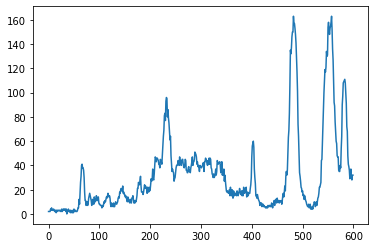

In [10]:
plt.plot(data_crop)

## Generate a psf data source from the 3D data for testing

In [11]:
psf_source = exp_data_3d[30,:,512]

In [12]:
psf_source.shape

(1026,)

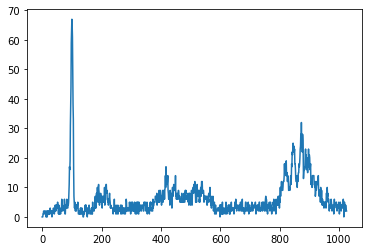

In [13]:
plt.plot(psf_source)

## RL deconvolution, user code

In [14]:
def RL0(data, psf, niter, do_edge_norm=True):
    #print("data.shape :",data.shape)
    #print("psf shape :", psf.shape)
    #Uses normalisation of data for extended size

    #Check data is one dim
    if data.ndim!= 1 and psf.ndim!=1:
        print ("Error: data and/or psf are not 1D. Returning None")
        return None
    
    # #Make sure data shape is even by cropping extra if needed
    # if data.shape[0] % 2 != 0 :
    #     data = data[:-1]
    #     print("new data.shape :",data.shape)

    #make sure psf is normalised sum
    psf0 = psf/ psf.sum()

    #Create a psf-like array that will be used to resize data
    delta_arr = np.zeros_like(psf0)
    phw = int(psf0.shape[0]/2) #Half-width of the psf
    delta_arr[ phw ] = 1.0
    data_shaped = np.convolve(data, delta_arr, mode='full')
    #print("data_shaped shape:", data_shaped.shape)

    #Create a normalisation array
    # a technique that helps slowing the reduction of edge effects with growing niter
    onesarray = np.ones_like(data)
    normarray = np.convolve(onesarray, psf0,mode='full')

    psf0_flip = np.flip(psf0)

    xn1 = np.array(data) #Initialise copy

    for i in range(niter):
        #print("iteration: ", i)
        xn=xn1
        #Convolution at denominator
        u0 = np.convolve(xn, psf0, mode='full')
        #print("u0 shape:", u0.shape)

        #Division
        div0 = data_shaped / u0 #TODO: check sizes are compatible

        #Convolve the result with flipped psf
        u2 = np.convolve(div0,psf0_flip, mode='same') #Use same setting to crop result
        #print("u2 shape:", u2.shape)

        #Multiplication with previous estimation
        #mult0 = np.multiply(xn, u2) #Error in sizes, should use extended previous estimation
        xn_ext = np.convolve(xn, delta_arr, mode='full')
        #print("xn_ext shape:", xn_ext.shape)

        mult0 = np.multiply(xn_ext,u2)

        norm0 = None
        #Optionally divide with normalisation array
        if do_edge_norm==True:
            norm0 = np.divide(mult0, normarray)
        else:
            norm0= mult0

        #crop result
        xn1 = norm0[phw:-phw+1]
        #print("xn1 shape:", xn1.shape)

    res = xn1

    return res

## max_valid_width vs niter and psf size

In [22]:
from scipy import signal
from numpy.random import default_rng
def crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, x_crop_0=100, x_crop_1=350, niter0=20, psf_half_width0=8 , psf_x_start=200):

    #Get maximum width
    def _get_max_width(data1d):
        maxwidth0=0
        width0=0
        for i in range(data1d.shape[0]):
            v0 = data1d[i]
            if v0==1:
                width0+=1
            else:
                width0==0
            maxwidth0 = max(maxwidth0,width0)
        return maxwidth0

    #create gaussian psf with given width
    psf_width0 = 2*psf_half_width0

    #Uses the data itself to get the psf
    psfdata_crop = psf_source[psf_x_start: psf_x_start+psf_width0]
    psf_norm0 = psfdata_crop / psfdata_crop.sum()

    #x_crop_0, x_crop_1 = 100 , 350
    data_crop0 = data[x_crop_0:x_crop_1]

    #RL deconvolution on the original data and in the cropped data
    deconv_skimageRL0 = RL0(data,psf_norm0, niter0, False)
    deconv_skimageRL_crop0 = RL0(data_crop0,psf_norm0, niter0, False)

    #Get difference and max_width
    diffsq0 = np.power( deconv_skimageRL_crop0 - deconv_skimageRL0[x_crop_0:x_crop_1 ], 2)
    diffsq_valid0 = diffsq0 < 1e-12
    m0 = _get_max_width(diffsq_valid0)
    return m0

In [23]:
#test,1 iteration
crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400, 1000 , 1)

570

Firt, study max_valid_width vs niter

## Get maxwidth as a function of number of iterations and psf size

In [24]:
niter_range = np.arange(1,50)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth = []
for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400,1000, niter0, phw0)
        print("niter0: ", niter0 , ", psf_width:", phw0 , ", maxwidth:", maxwidth)
        maxwidths_vs_niter_and_psfhwidth.append( (niter0,phw0,maxwidth) )

niter0:  1 , psf_width: 8 , maxwidth: 570
niter0:  1 , psf_width: 9 , maxwidth: 566
niter0:  1 , psf_width: 10 , maxwidth: 562
niter0:  1 , psf_width: 11 , maxwidth: 558
niter0:  1 , psf_width: 12 , maxwidth: 554
niter0:  1 , psf_width: 13 , maxwidth: 550
niter0:  1 , psf_width: 14 , maxwidth: 546
niter0:  1 , psf_width: 15 , maxwidth: 542
niter0:  1 , psf_width: 16 , maxwidth: 538
niter0:  1 , psf_width: 17 , maxwidth: 534
niter0:  1 , psf_width: 18 , maxwidth: 530
niter0:  1 , psf_width: 19 , maxwidth: 527
niter0:  1 , psf_width: 20 , maxwidth: 523
niter0:  1 , psf_width: 21 , maxwidth: 519
niter0:  1 , psf_width: 22 , maxwidth: 515
niter0:  1 , psf_width: 23 , maxwidth: 511
niter0:  1 , psf_width: 24 , maxwidth: 507
niter0:  1 , psf_width: 25 , maxwidth: 503
niter0:  1 , psf_width: 26 , maxwidth: 499
niter0:  1 , psf_width: 27 , maxwidth: 495
niter0:  1 , psf_width: 28 , maxwidth: 491
niter0:  1 , psf_width: 29 , maxwidth: 487
niter0:  1 , psf_width: 30 , maxwidth: 483
niter0:  1 , 

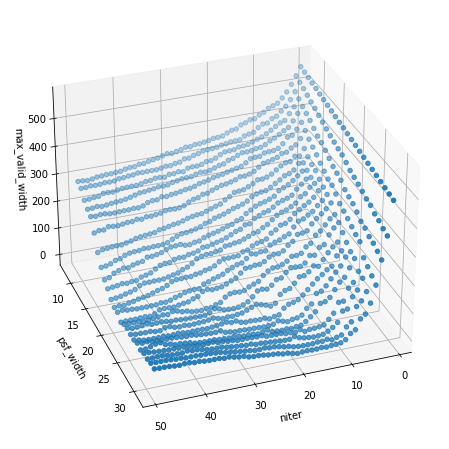

In [25]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', )
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth))
ax.set_xlabel('niter')
ax.set_zlabel('max_valid_width')
ax.set_ylabel('psf_width')
ax.view_init(azim=70)
plt.show()

## Compare with theoretical formula of 'valid' region after convolution

Assumning each RL (2 convolutions) leads to a valid size that is smaller than original data given by formula

$ M_n = m + n(2-2p)$

In [26]:
niter_range = np.arange(1,50)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth_RL= []
maxwidths_vs_niter_and_psfhwidth_theory = []

datacrop_width = data_crop.shape[0]

print(f"datacrop_width: {datacrop_width}")

for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400,1000, niter0, phw0)
        maxwidths_vs_niter_and_psfhwidth_RL.append( (niter0,phw0,maxwidth) )

        maxwidth_theory = datacrop_width + niter0*(2-4*phw0)
        if maxwidth_theory>0:
            maxwidths_vs_niter_and_psfhwidth_theory.append((niter0,phw0, maxwidth_theory))

        print("niter0: ", niter0 , ", psf_half_width:", phw0 , ", maxwidth:", maxwidth, " maxwidth_theory:", maxwidth_theory)


datacrop_width: 600
niter0:  1 , psf_half_width: 8 , maxwidth: 570  maxwidth_theory: 570
niter0:  1 , psf_half_width: 9 , maxwidth: 566  maxwidth_theory: 566
niter0:  1 , psf_half_width: 10 , maxwidth: 562  maxwidth_theory: 562
niter0:  1 , psf_half_width: 11 , maxwidth: 558  maxwidth_theory: 558
niter0:  1 , psf_half_width: 12 , maxwidth: 554  maxwidth_theory: 554
niter0:  1 , psf_half_width: 13 , maxwidth: 550  maxwidth_theory: 550
niter0:  1 , psf_half_width: 14 , maxwidth: 546  maxwidth_theory: 546
niter0:  1 , psf_half_width: 15 , maxwidth: 542  maxwidth_theory: 542
niter0:  1 , psf_half_width: 16 , maxwidth: 538  maxwidth_theory: 538
niter0:  1 , psf_half_width: 17 , maxwidth: 534  maxwidth_theory: 534
niter0:  1 , psf_half_width: 18 , maxwidth: 530  maxwidth_theory: 530
niter0:  1 , psf_half_width: 19 , maxwidth: 527  maxwidth_theory: 526
niter0:  1 , psf_half_width: 20 , maxwidth: 523  maxwidth_theory: 522
niter0:  1 , psf_half_width: 21 , maxwidth: 519  maxwidth_theory: 518
ni

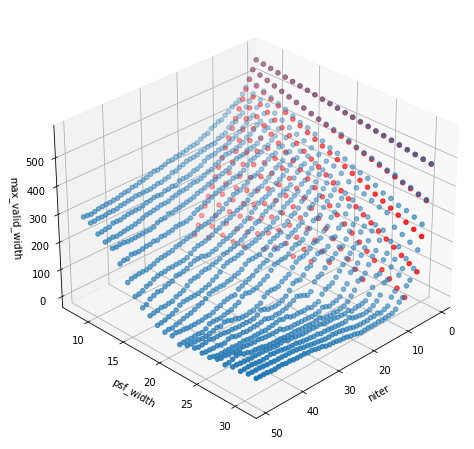

In [27]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', )
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth_RL))
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth_theory), c='red')
ax.set_xlabel('niter')
ax.set_zlabel('max_valid_width')
ax.set_ylabel('psf_width')
ax.view_init(azim=45)
plt.show()

Interesting. The theoretical formula predicts that the decrease in max_valid_width should decrease linearly with niter. This is true at the first niter, but with increasing niter it curves up

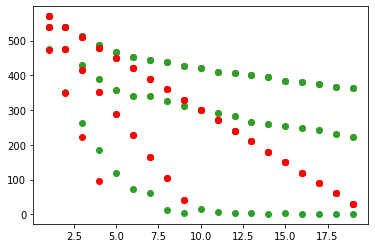

In [28]:
niter_range = np.arange(1,20)
psf_hwidth_range = [8, 16, 32]

maxwidths_vs_niter= []
maxwidths_vs_niter_theor=[]

datacrop_width = data_crop.shape[0]

for phw0 in psf_hwidth_range:
    for niter0 in niter_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400,1000, niter0, phw0)
        maxwidths_vs_niter.append( (niter0,maxwidth) )

        maxwidth_theory = datacrop_width + niter0*(2-4*phw0)
        if maxwidth_theory>0:
            maxwidths_vs_niter_theor.append((niter0, maxwidth_theory))
    plt.scatter(*zip(*maxwidths_vs_niter))
    plt.scatter(*zip(*maxwidths_vs_niter_theor), c='red')

plt.show()
